# Get stationary time series 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm
from random import seed, randint
import utils
from cnn_graph.lib import graph

In [2]:
# Load data
dist_geo = pd.read_csv("data/distance_paris.csv",header=0,index_col=0)
X_hour = pd.read_csv("data/X_hour_paris.csv",header=0,index_col=0)
T_1, N = X_hour.shape
T_0 = int(X_hour.shape[0]*0.9)
T_tv = int(T_0*0.95)

## Weekly profile !only use the training set to get the profile!
X_train = X_hour.iloc[:T_tv,].copy()
index = np.tile(np.arange(1,24*7+1), np.int(X_hour.shape[0]/24/7)+1)[:X_hour.shape[0]] - 1
X_train['index'] = index[:T_tv]
wk_pf = X_train.groupby('index').mean()
X_train = X_train.drop(columns = "index")

X_hour, wk_pf = [np.float32(x) for x in [X_hour, wk_pf]]
X_hour_detrend = np.copy(X_hour) - wk_pf[index,:]

## Scale, to make the regularization parameter lambda have the same influence on all var.
X_train = X_hour_detrend[:T_tv,]
sd = X_train.std(axis = 0)
X_hour_detrend_sc = np.multiply(X_hour_detrend , 1/sd)
X_train, X_val, X_test = [X_hour_detrend_sc[:T_tv,], X_hour_detrend_sc[T_tv:T_0,], X_hour_detrend_sc[T_0:,]]

In [3]:
# Sampling size is given
P = int(0.1*N)
print(P)

27


# Algorithm 1: H = 0
## Sensor selection on training set

In [4]:
# Input
Sigma_hat = np.cov(X_train.T, bias=True)

In [5]:
I0 = utils.alg1(Sigma_hat, P)
Ic0 = list(set(range(N)) - set(I0)) 
print(I0) # Sensor Selection results

[5, 209, 73, 239, 155, 112, 74, 132, 30, 224, 226, 238, 229, 205, 255, 260, 117, 72, 227, 17, 34, 257, 114, 61, 42, 31, 254]


## Reconstruction performance on test set

In [6]:
[X_I_hat0, err_mse0] = utils.ReLin0(I0, Sigma_hat, X_test[:,Ic0], X_test[:,I0])
print("The reconstruction error on the test set is: {}.".format(err_mse0))

The reconstruction error on the test set is: 32.53084803746574.


## Comparison with baseline:  random sampling

In [7]:
err_mse_rand0 = np.zeros(30)
for i in range(30):
    I_rand = np.random.choice(N, P, replace=False)
    Ic_rand = list(set(range(N)) - set(I_rand)) 
    [_, err_mse_rand0[i]] = utils.ReLin0(I_rand, Sigma_hat, X_test[:,Ic_rand], X_test[:,I_rand])
print("The average reconstruction error for random sampling set on the test set is: {}.".format(err_mse_rand0.mean()))

The average reconstruction error for random sampling set on the test set is: 41.76286183230103.


In [8]:
# Get the predictions of the original time series
X_I_hat0 = np.multiply(X_I_hat0, sd[I0]) # Multiply the std back
X_I_hat0 += wk_pf[index[T_0:],:][:,I0] # Add the trend back

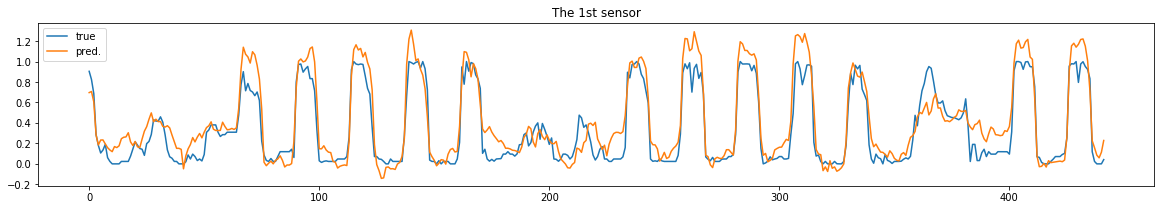

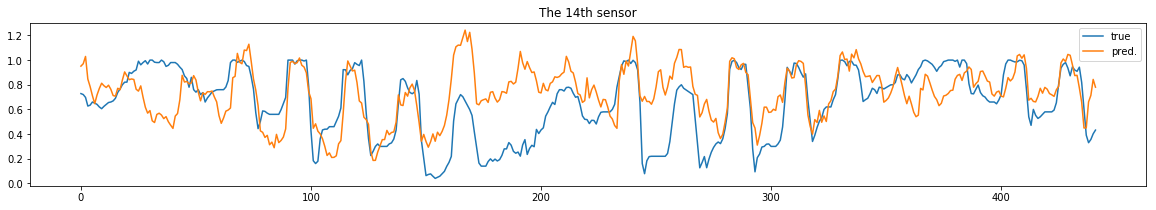

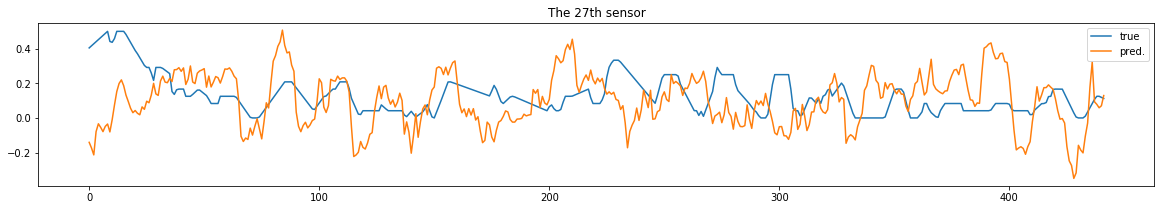

In [9]:
# Visualization
plt.rcParams["figure.figsize"] = (20,3)
plt.figure()
plt.plot(X_hour[T_0:,][:,I0][:,0], label = "true")
plt.plot(X_I_hat0[:,0], label = "pred.")
plt.title("The 1st sensor")
plt.legend()
plt.figure()
plt.plot(X_hour[T_0:,][:,I0][:,int(P/2)], label = "true")
plt.plot(X_I_hat0[:,int(P/2)], label = "pred.")
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0:,][:,I0][:,P-1], label = "true")
plt.plot(X_I_hat0[:,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

# Algorithm 2/4: H > 0, with linear ridge regression
## Sensor selection on training set, hyperparameters $\lambda$ tuning on validation set

In [7]:
grid = []
err = []
I_collection = []

G_H = [1]
for H in G_H:
    print("H = {:}".format(H))
    AlphaH = multi_dot([X_train[H:,:].T, X_train[H:,:]])
    for l_col in np.arange(H)+1:
        AlphaH = np.append(AlphaH, multi_dot([X_train[H:,:].T, X_train[(H-l_col):(T_tv-l_col),:]]), axis = 1) 
    AlphaH /= T_tv
    AlphaH = utils.btoep(AlphaH)
    
    # Estimate the largest eigenvalue so as to set the grid for lambda
    eig_max = utils.power_iteration(AlphaH, 10)    
    Pi = eig_max*np.linspace(0.001, 0.01, num = 5)
    
    for lda in Pi:
        I = utils.alg2(Sigma_hat, AlphaH, P, H, lda = lda, inv_method = 'cg', tol = 0.001*AlphaH.std())
        Ic = list(set(range(N)) - set(I)) 
        # Reconstruction on validation set
        X_val_H_Ic = X_val[H:,Ic]
        T = X_val.shape[0]
        for l in np.arange(H)+1:
            X_val_H_Ic = np.append(X_val_H_Ic, X_val[(H-l):(T-l),Ic], axis = 1)  
        [X_I_hat_H, err_mse_H] = utils.ReLinH(I, H, AlphaH, X_val_H_Ic, X_val[H:,I], lda = lda, inv_method = 'cg', tol = 0.001*AlphaH.std())
        
        print("Lambda is: {: 3.3f}, the reconstruction error on validation set is: {: 3.3f}. \n".format(lda, err_mse_H))
        grid.append((H, lda))
        err.append(err_mse_H)
        I_collection.append(I)

(H, lda) = grid[np.argmin(err)]
I_H = I_collection[np.argmin(err)]
Ic_H = list(set(range(N)) - set(I_H)) 
print(H, lda)
print(I_H)

H = 1
power iteration:
The tolerance 0.100 has been reached. The number of iterations is: 6
The percentage done is: 0.00
The percentage done is: 0.04
The percentage done is: 0.22
The percentage done is: 0.41
The percentage done is: 0.44
The percentage done is: 0.63
The percentage done is: 0.81
Lambda is:  0.074, the reconstruction error on validation set is:  19.621. 

The percentage done is: 0.00
The percentage done is: 0.04
The percentage done is: 0.22
The percentage done is: 0.41
The percentage done is: 0.44
The percentage done is: 0.63
The percentage done is: 0.81
Lambda is:  0.241, the reconstruction error on validation set is:  17.600. 

The percentage done is: 0.00
The percentage done is: 0.04
The percentage done is: 0.22
The percentage done is: 0.41
The percentage done is: 0.44
The percentage done is: 0.63
The percentage done is: 0.81
Lambda is:  0.407, the reconstruction error on validation set is:  16.553. 

The percentage done is: 0.00
The percentage done is: 0.04
The percen

## Reconstruction performance on test set

In [8]:
AlphaH = multi_dot([X_train[H:,:].T, X_train[H:,:]])
for l_col in np.arange(H)+1:
    AlphaH = np.append(AlphaH, multi_dot([X_train[H:,:].T, X_train[(H-l_col):(T_tv-l_col),:]]), axis = 1) 
AlphaH /= T_tv
AlphaH = utils.btoep(AlphaH)

X_test_H_Ic = X_test[H:,Ic_H]
T = X_test.shape[0]
for l in np.arange(H)+1:
    X_test_H_Ic = np.append(X_test_H_Ic, X_test[(H-l):(T-l),Ic_H], axis = 1)     
[X_I_hat_H, err_mse_H] = utils.ReLinH(I_H, H, AlphaH, X_test_H_Ic, X_test[H:,I_H], lda = lda, inv_method = 'cg', tol = 0.001*AlphaH.std())

print("The reconstruction error on the test set is: {}.".format(err_mse_H))

The reconstruction error on the test set is: 23.810921289577152.


In [9]:
# Get the predictions of the original time series
X_I_hat_H = np.multiply(X_I_hat_H, sd[I_H]) # Multiply the std back
X_I_hat_H += wk_pf[index[T_0+H:],:][:,I_H] # Add the trend back

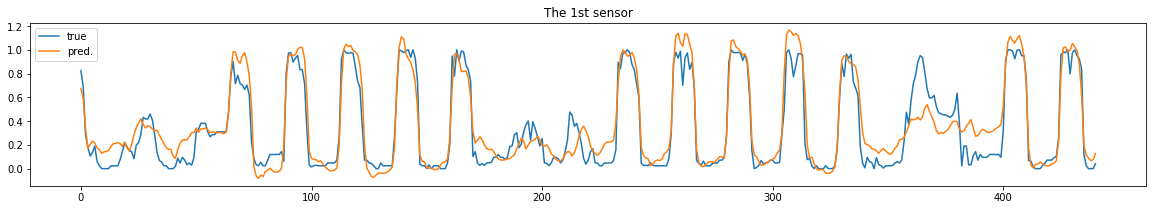

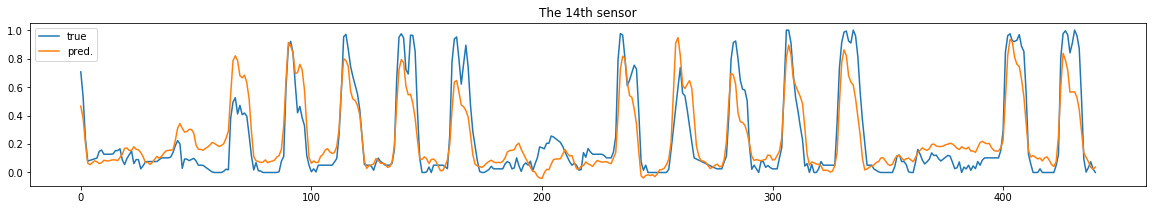

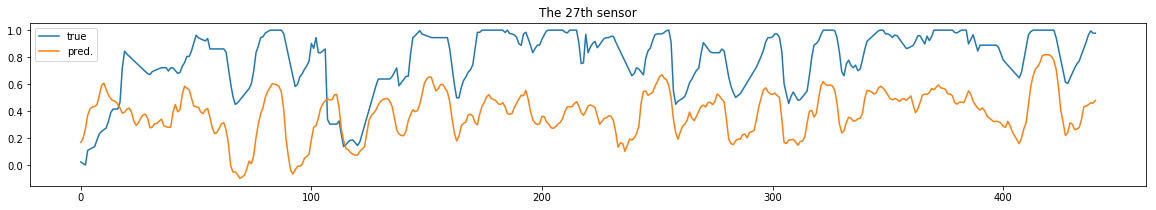

In [10]:
# Visualization
plt.rcParams["figure.figsize"] = (20,3)
plt.figure()
plt.plot(X_hour[T_0+H:,][:,I_H][:,0], label = "true")
plt.plot(X_I_hat_H[:,0], label = "pred.")
plt.title("The 1st sensor")
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:,][:,I_H][:,int(P/2)], label = "true")
plt.plot(X_I_hat_H[:,int(P/2)], label = "pred.")
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:,][:,I_H][:,P-1], label = "true")
plt.plot(X_I_hat_H[:,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

## Comparison with baseline:  random sampling

In [11]:
err_mse_rand_H = np.zeros(100)
for i in range(100):
    I_rand = np.random.choice(N, P, replace=False)
    Ic_rand = list(set(range(N)) - set(I_rand)) 
    X_test_H_Ic_rand = X_test[H:,Ic_rand]
    T = X_test.shape[0]
    for l in np.arange(H)+1:
        X_test_H_Ic_rand = np.append(X_test_H_Ic_rand, X_test[(H-l):(T-l),Ic_rand], axis = 1)     
    [X_I_hat_H_rand, err_mse_rand_H[i]] = utils.ReLinH(I_rand, H, AlphaH, X_test_H_Ic_rand, X_test[H:,I_rand], lda = lda, inv_method = 'cg')
print("The average reconstruction error for random sampling set on the test set is: {}.".format(err_mse_rand_H.mean()))

The average reconstruction error for random sampling set on the test set is: 30.45224055919531.
